In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
from pymc3.backends import Text
import matplotlib.pyplot as plt
import re

%matplotlib inline

## Pre-Processing

In [2]:
# Import season 2013/14 fixtures
df = pd.read_csv('./data/ts14-15.csv')
df = df.drop('Unnamed: 0', 1)

# Build team index
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

df = df.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

# Add back to back fixture round index t
fixtures_per_round = num_teams/2
num_rounds = 38

rounds = np.array([[x]*(fixtures_per_round) for x in range(1,39)]).flatten()
df['t'] = 1
df['t'] = rounds

T = observed_home_goals.shape[0]

df[1:19]

,home_score,away_score,kick_off,home_team,away_team,i_home,i_away,t
56,1,2,2014-08-16,Manchester United,Swansea City,2,19,1
274,0,1,2014-08-16,West Ham United,Tottenham Hotspur,14,8,1
10,2,1,2014-08-16,Arsenal,Crystal Palace,0,11,1
340,0,1,2014-08-16,Queens Park Rangers,Hull City,17,18,1
235,2,2,2014-08-16,Leicester City,Everton,12,7,1
202,2,2,2014-08-16,West Bromwich Albion,Sunderland,10,13,1
62,2,1,2014-08-17,Liverpool,Southampton,3,6,1
84,0,2,2014-08-17,Newcastle United,Manchester City,4,9,1
305,1,3,2014-08-18,Burnley,Chelsea,16,1,1
377,1,0,2014-08-23,Swansea City,Burnley,19,16,2


## Model Definition

In [8]:
trace_len = 10000
num_weeks = 38

models = []

# If run with T == 1, only fit timestep 1 without AR
for t in range(1,num_weeks+1):
    print "\nTrain week %d of %d (i=%d)" %(t, num_weeks, t)

    with pm.Model() as exp_1:    
        # global model parameters
        home = pm.Normal('home', mu=0, tau=0.0001)
        tau_att = pm.Gamma('tau_att', alpha=0.1, beta=0.1)
        tau_def = pm.Gamma('tau_def', alpha=0.1, beta=0.1)
        intercept = pm.Normal('intercept', mu=0, tau=0.0001)

        atts_star   = pm.Normal("atts_star",
                               mu = 0,
                               tau = tau_att,
                               shape = num_teams)
        defs_star   = pm.Normal("defs_star",
                               mu = 0,
                               tau = tau_def,
                               shape = num_teams)
        # Identifieability
        atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
        defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
        home_theta  = tt.exp(intercept + home + atts[home_team[:t*10]] + defs[away_team[:t*10]])
        away_theta  = tt.exp(intercept + atts[away_team[:t*10]] + defs[home_team[:t*10]])

        # Likelihood
        home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals[:t*10])
        away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals[:t*10])
        
        models.append(exp_1)
        
        # Sampling
        # If no previous model runs, find map as starting point
        # otherwise use estimates from previous model run
        # No starting point for atts_ni{t+1} and defs respectively, could use atts_ni{t} estimates instead
#         if (t == 1):
#             start = pm.find_MAP()
#         else:
#             tracename = "trace_exp_1_nuts_" + str(t-1)
            
#             print "Load last trace '" + tracename + "'"
            
#             trace_loaded = pm.backends.text.load(tracename)
#             pattern = re.compile("(atts\d|defs\d|.*_ni" + str(t) + ")")
#             start = {key: np.mean(trace_loaded[key], axis=0) for key in trace_loaded.varnames if pattern.match(key) == None}
            
#         # step = pm.NUTS()
#         step = pm.NUTS()
#         db = Text("trace_exp_1_nuts_{0}".format(t))
#         trace = pm.sample(trace_len, step, start=start, trace=db)


Train week 1 of 38 (i=1)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 2 of 38 (i=2)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 3 of 38 (i=3)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 4 of 38 (i=4)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 5 of 38 (i=5)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 6 of 38 (i=6)
Applied log-transform to tau_att and added transformed tau_att_log to mode

## Analyse Convergence

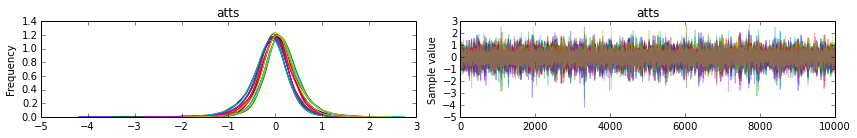

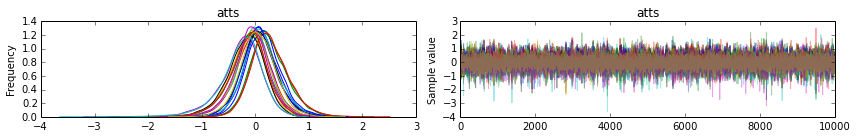

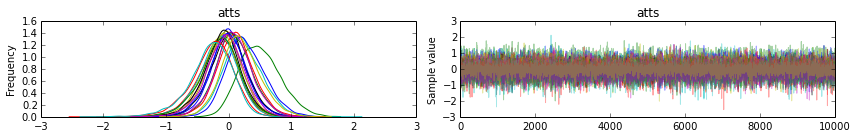

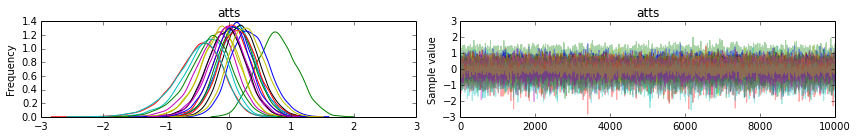

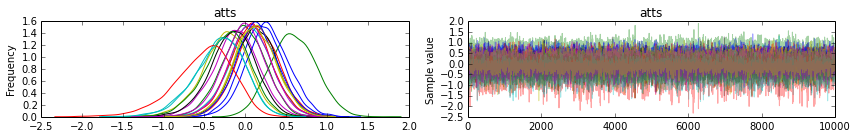

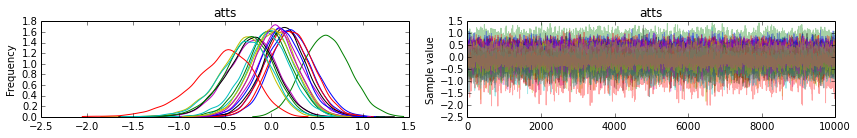

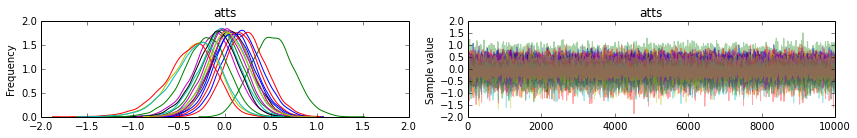

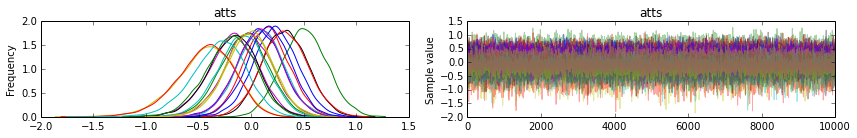

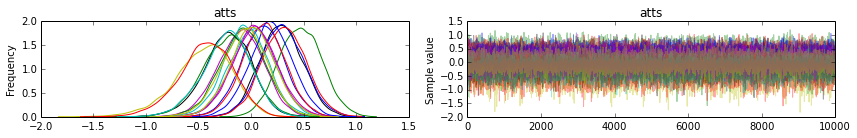

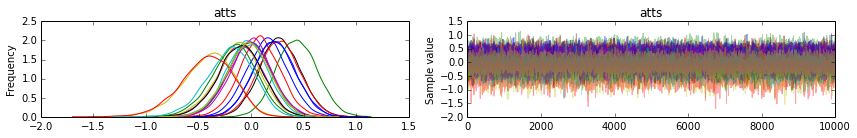

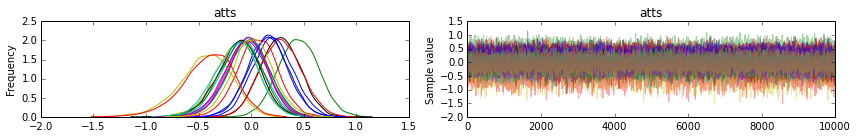

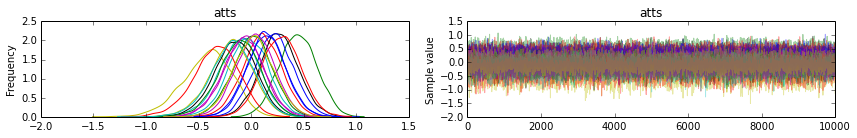

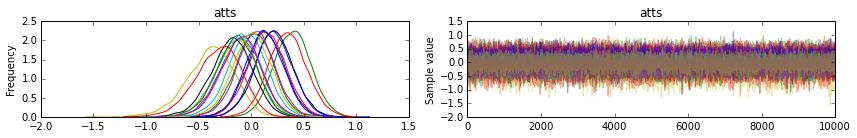

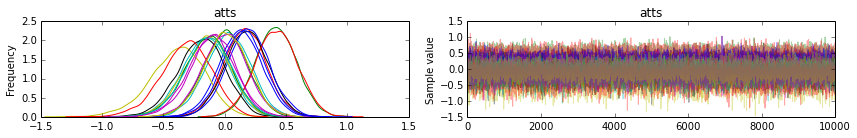

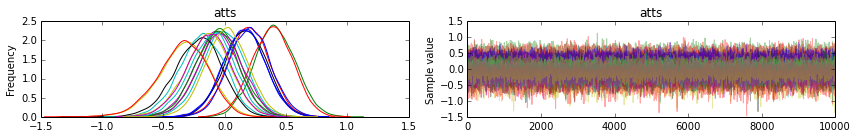

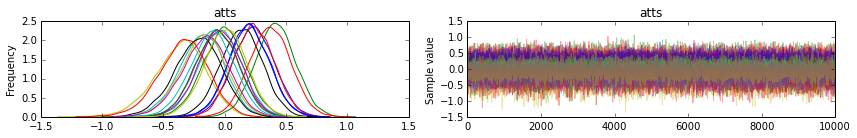

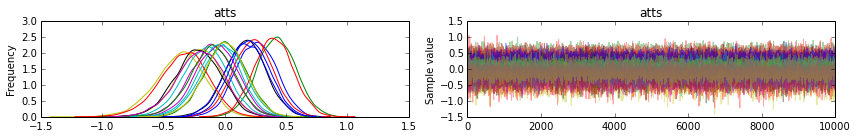

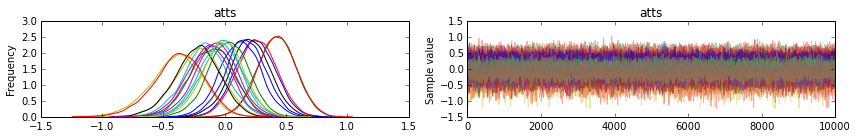

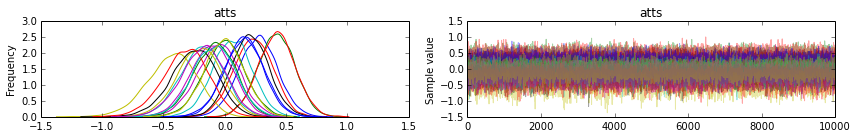

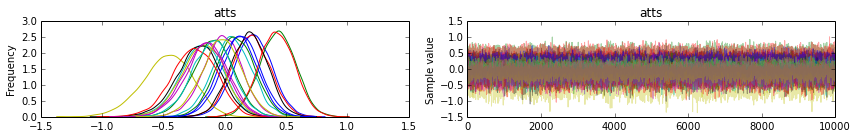

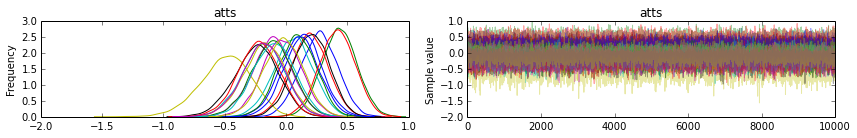

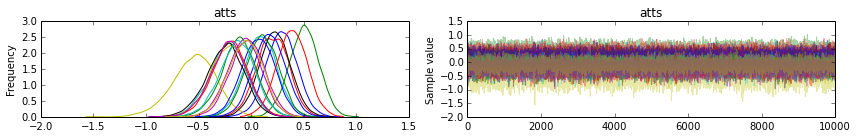

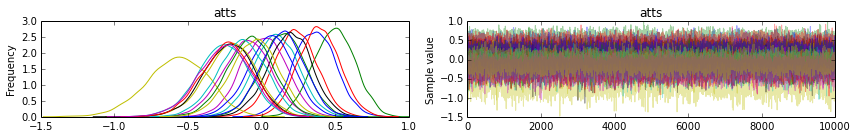

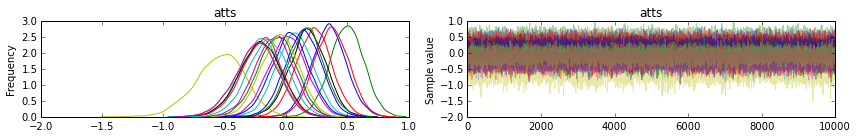

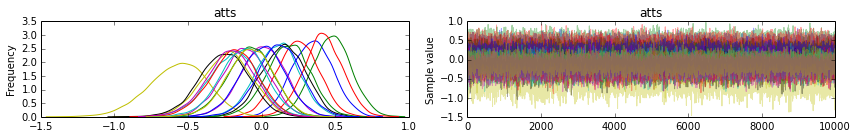

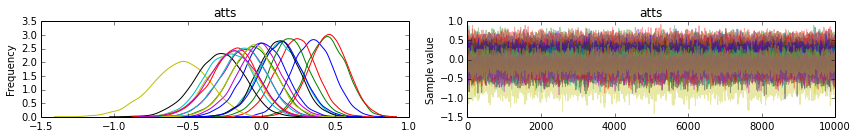

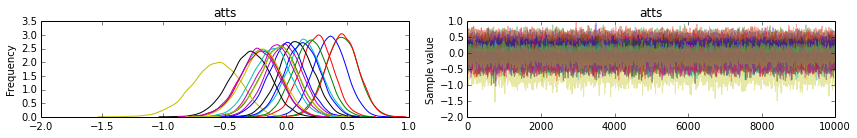

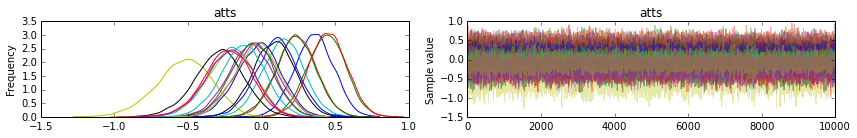

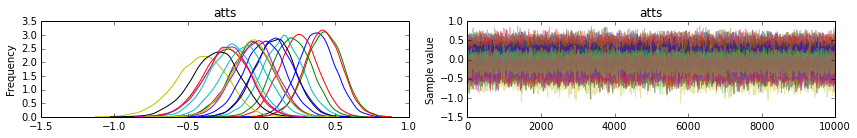

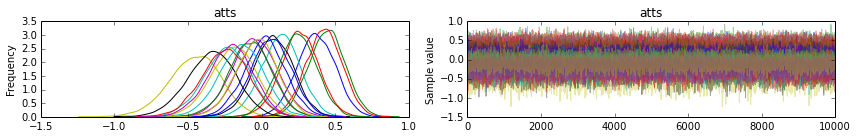

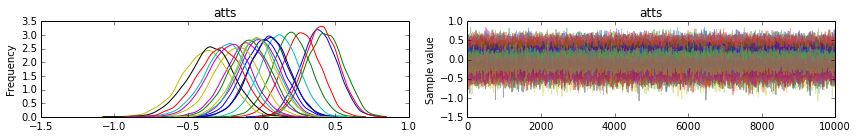

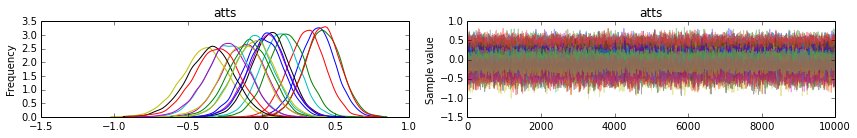

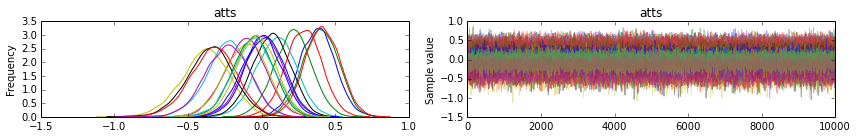

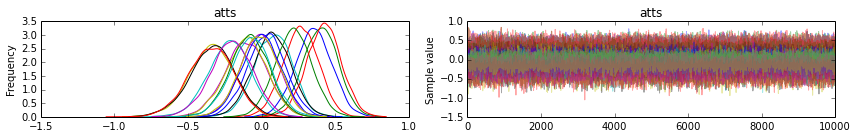

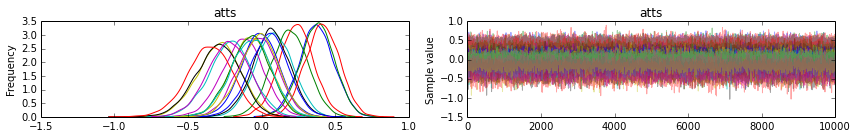

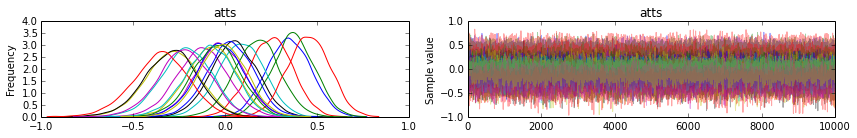

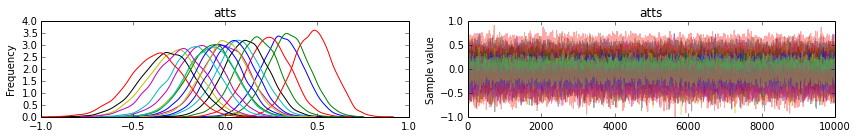

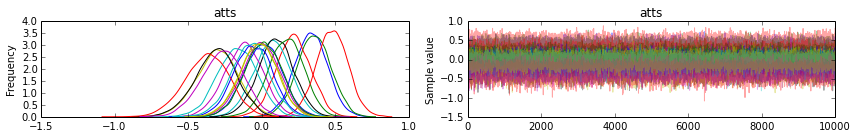

In [30]:
traces = []

for k, m in enumerate(models):
    with m:
        tracename = "/Users/moe/Development/busics/thesis/notebooks/nuts/nuts_trace_exp_1_" + str(k+1)
        trace = pm.backends.text.load(tracename)
        traces.append(trace)
        pm.traceplot(trace, [atts])

## Predictive Analysis: 1-Step ahead prediction

In [91]:
observed_home_goals.shape

(380,)

In [128]:
from scipy.stats import poisson

num_weeks = 38
ll = 0

for w in range(0, num_weeks):
    # Get fixtures and trace for week w
    a = away_team[w*10:w*10+10]
    h = home_team[w*10:w*10+10]
    t = traces[w]
    act_home = observed_home_goals[w*10:w*10+10]
    act_away = observed_away_goals[w*10:w*10+10]
    
    # Get samples for all 10 fixtures (20 teams) of week w
    home = t['home']
    intercept = t['intercept']
    atts = np.swapaxes(t['atts'],0,1)
    defs = np.swapaxes(t['defs'],0,1)

    # 10k compositions of home and away scoring intensity parameter -> distribution
    lbda_home = np.exp(home + atts[h] + defs[a] + intercept)
    lbda_away = np.exp(atts[a] + defs[h] + intercept)
    sim_home = poisson.rvs(lbda_home)
    sim_away = poisson.rvs(lbda_away)

    # Prediction: Counting realisations equaling actual outcome
    sim_home = np.swapaxes(sim_home,0,1)
    l = sum(sim_home == act_home)/float(10000)
    ll += sum(np.log(l))
    
avg_ll = ll/380

print "Average Model Likelihood: %f" %(np.exp(avg_ll))

Average Model Likelihood: 0.236113


In [86]:
test = np.array([[1, 1, 1],[2, 2, 2]])
test+1

array([[2, 2, 2],
       [3, 3, 3]])

In [ ]:
from scipy.stats import poisson

# Week-wise 1-step ahead prediction
num_weeks = 5
num_games = num_weeks * 10
ll = 0

for w in range(0, num_weeks):    
    t = traces[w]

    home_mean = t['home'].mean()
    intercept_mean = t['intercept'].mean()
    defs_mean = t["atts"].mean(axis=0)
    atts_mean = t["defs"].mean(axis=0)

    # Given week 1, predict week 2 (ten games a week)
    # Only looking at strength parameter of present week!? -> D-Separated with t-1 parameters???
    lbda_home = np.exp(home_mean + atts_mean[home_team[w]] + defs_mean[away_team[w]] + intercept_mean)
    lbda_away = np.exp(atts_mean[away_team[w]] + defs_mean[home_team[w]] + intercept_mean)

    # Prediction: Sampling from Independent Poisson
    p_home = poisson.pmf(observed_home_goals[1], lbda_home)
    p_away = poisson.pmf(observed_away_goals[1], lbda_away)

    # Multiply all home and away probabilites as well as the ten games, transform to log space 
    ll += np.log(np.prod(p_home * p_away))

print "Average Log-Likelihood of Season 14/15: " + str(ll / num_games)

## Descriptive Analysis: Evolution of team strength parameters

In [ ]:
# Same evolution plot as before, after training on all observations